In [92]:
import jax
# Enable Float64 for more stable matrix inversions.
jax.config.update("jax_enable_x64", True)

from dataclasses import dataclass
import warnings
from typing import List, Union
import pandas as pd
import cola


import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
    Num,
)
import tensorflow_probability.substrates.jax.bijectors as tfb
import optax as ox

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
from gpjax.typing import (
    Array,
    ScalarFloat,
)
from gpjax.distributions import GaussianDistribution
from gpjax.kernels import AdditiveKernel

import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.style.use(
#     "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
# )
# colors = rcParams["axes.prop_cycle"].by_key()["color"]
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
mpl.rcParams.update(mpl.rcParamsDefault)

#imports AdditiveConjugatePosterior
# from OAK import AdditiveConjugatePosterior

from pprint import pprint
import numpy as np
def calculate_nlpd(predictive_mean, predictive_stddev, actual_values):
    variance = predictive_stddev ** 2
    nlpd_sum = 0.5 * np.log(2 * np.pi * variance) + ((predictive_mean - actual_values) ** 2) / (2 * variance)
    total_nlpd = np.sum(nlpd_sum)
    return total_nlpd

## This is where I shall add in the dataset

This can be changed according to which data is useful and can be found in GPJAX/docs/examples/datasets



In [93]:
# dataset_path = "/home/sharmakd/python_dev/GPJax/docs/examples/datasets/real_estaate_evaluation/Real estate valuation data set.csv"
# mydata = pd.read_csv(dataset_path, sep=',')
# mydata.columns = ['Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water', 'Superplasticizer', 'CoarseAggregate', 'FineAggregate', 'Age', 'Strength']

# mydata = mydata[:100]
# y = mydata['Y house price of unit area']
# X = mydata.drop(columns=['Y house price of unit area', 'No'])
# X = mydata[['Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water', 'Superplasticizer']]

def f1(x):
    return x**2

def f2(x):
    return jnp.sin(x)

def f3(x):
    return jnp.cos(x**2) 

def f4(x):
    return x**3

def f5(x):
    return jnp.exp(x)

lof = [f1,f2,f3,f4,f5]

def f(x):
    return sum([lof[i](x[:,i:i+1]) for i in range(len(lof))])



n, noise = 400, 0.001
key = jax.random.PRNGKey(np.random.randint(50))  # Replace 12345 with any desired seed value
X = jr.uniform(key, (n, len(lof)))
y = f(X) + jr.normal(key, (n, 1)) * noise
#Select Data wanted
X = jnp.array(X)
# y = jnp.array(y).reshape(-1, 1) 
D = gpx.Dataset(X, y)
feature_dimension = X.shape[1]

# Split the data into training and test sets
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.1, random_state=42)
print(Xtr.shape, Xte.shape, ytr.shape, yte.shape)

(360, 5) (40, 5) (360, 1) (40, 1)


In [94]:
# prepare some plotting utilities
NumPoints = 50
min, max = -4, 4

#Need to implement general nd mesh grid and 2d plot points to estimate points
# x1_plot, x2_plot, x3_plot = jnp.meshgrid(jnp.linspace(min,max,NumPoints), jnp.linspace(min,max,NumPoints),jnp.linspace(min,max,NumPoints))
# xplot2d = jnp.stack([x1_plot.reshape(-1), x2_plot.reshape(-1), x3_plot.reshape(-1)]).T # array of points to test on  make the 2 feature dimension
# xplot1d = jnp.stack([jnp.linspace(-min,max,NumPoints) for _ in range(feature_dimension)]).T # [NumPoints, feature dimension]
# print(xplot2d[0:10])

def mesh2d(active_dimensions: list[int] = [], min = min, max = max, NumPoints = NumPoints):
    if len(active_dimensions) not in [1,2]:
        raise ValueError("Only 1 or 2 active dimensions are supported")
    xn_plot = []
    for i in range(feature_dimension):
        if i in active_dimensions:
            xn_plot += [jnp.linspace(min, max, NumPoints)]
        else:
            xn_plot += [jnp.array([0])]
    print(xn_plot)
    xn_meshgrid = jnp.meshgrid(*xn_plot)
    xplot2d = jnp.stack([x.reshape(-1) for x in xn_meshgrid], axis=-1)
    return xplot2d

# xn_plot = [jnp.linspace(min, max, NumPoints) for _ in range(feature_dimension)]
# xn_meshgrid = jnp.meshgrid(*xn_plot)
# xplot2d = jnp.stack([x.reshape(-1) for x in xn_meshgrid], axis=-1)

xplot1d = jnp.stack([jnp.linspace(min, max, NumPoints) for _ in range(feature_dimension)]).T
x1_plot, x2_plot = jnp.meshgrid(jnp.linspace(min, max, NumPoints), jnp.linspace(min, max, NumPoints))

def contour_plot(Z, ax):
    Z = Z.reshape(NumPoints, NumPoints)
    cp = ax.contourf(x1_plot, x2_plot, Z)
    ax.scatter(X[:,0], X[:,1], c="red", marker="x", label="data")
    ax.set_xlim(min,max)
    ax.set_ylim(min,max)



[Array([-4.        , -3.83673469, -3.67346939, -3.51020408, -3.34693878,
       -3.18367347, -3.02040816, -2.85714286, -2.69387755, -2.53061224,
       -2.36734694, -2.20408163, -2.04081633, -1.87755102, -1.71428571,
       -1.55102041, -1.3877551 , -1.2244898 , -1.06122449, -0.89795918,
       -0.73469388, -0.57142857, -0.40816327, -0.24489796, -0.08163265,
        0.08163265,  0.24489796,  0.40816327,  0.57142857,  0.73469388,
        0.89795918,  1.06122449,  1.2244898 ,  1.3877551 ,  1.55102041,
        1.71428571,  1.87755102,  2.04081633,  2.20408163,  2.36734694,
        2.53061224,  2.69387755,  2.85714286,  3.02040816,  3.18367347,
        3.34693878,  3.51020408,  3.67346939,  3.83673469,  4.        ],      dtype=float64), Array([-4.        , -3.83673469, -3.67346939, -3.51020408, -3.34693878,
       -3.18367347, -3.02040816, -2.85714286, -2.69387755, -2.53061224,
       -2.36734694, -2.20408163, -2.04081633, -1.87755102, -1.71428571,
       -1.55102041, -1.3877551 , -1.22448

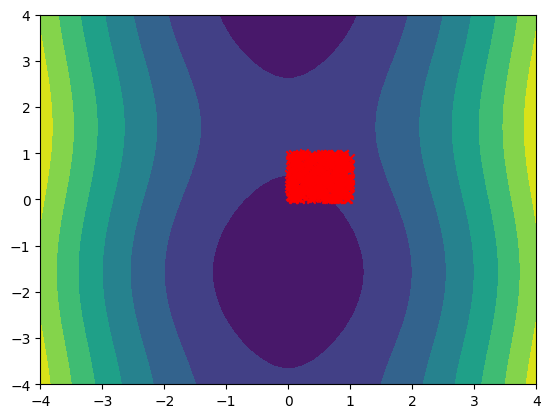

In [95]:
fig, ax = plt.subplots()
xplot2d = mesh2d(active_dimensions=[0,1])
contour_plot(f(xplot2d), ax)
plt.show()

## This step is to test datasets to see if they need scaling or transforming

In [96]:
class AdditiveConjugatePosterior(gpx.gps.ConjugatePosterior):
    r"""        
    Build an additive posterior from an additive kernel and a Gaussian likelihood. We have included an
    additional method to allow predictions for specific additive components, as specified by a
    component_list, e.g. [0, 1] corresponds to the second order interaction between zeroth and first inputs.
    """

    def __post__init__(self):
        assert isinstance(self.prior.kernel, AdditiveKernel), "AdditiveConjugatePosterior requires an AdditiveKernel"

    def predict_additive_component(
        self,
        test_inputs: Num[Array, "N D"],
        train_data: gpx.Dataset,
        component_list: List[List[int]]
    ) -> GaussianDistribution:
        r"""Get the posterior predictive distribution for a specific additive component."""
        specific_kernel = self.prior.kernel.get_specific_kernel(component_list)
        return self.predict(test_inputs, train_data, kernel_with_test = specific_kernel)

    def get_sobol_index(self, train_data: gpx.Dataset, component_list: List[int]) -> ScalarFloat:
        """ Return the sobol index for the additive component corresponding to component_list. """
        component_posterior = self.predict_additive_component(train_data.X, train_data, component_list)
        full_posterior= self.predict(train_data.X, train_data) # wasteful as only need means
        return jnp.var(component_posterior.mean()) / jnp.var(full_posterior.mean())

@dataclass()
class OrthogonalRBF(gpx.kernels.AbstractKernel):
    r"""todo only for unit gaussian input measure and zero mean."""
    name: str = "OrthogonalRBF"
    lengthscale: Union[ScalarFloat, Float[Array, " D"]] = gpx.param_field(
        jnp.array(1.0), bijector=tfb.Softplus()
    )

    def __post_init__(self):
        warnings.warn("This kernel is only valid for unit gaussian input measures and zero mean functions.")

    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute an orthogonal RBF kernel between a pair of arrays."""
        x = self.slice_input(x) # [d]
        y = self.slice_input(y) # [d]
        ks = jnp.exp(-0.5 * ((x - y) / self.lengthscale) ** 2) # [d]
        ks -=  self._cov_x_s(x) * self._cov_x_s(y) / self._var_s() # [d]
        return jnp.prod(ks)
    
    def _cov_x_s(self,x):
        l2 = self.lengthscale ** 2
        return jnp.sqrt(l2 / (l2 + 1.0)) * jnp.exp(-0.5 * (x ** 2) / (l2 + 1.0)) # [d]
        
    def _var_s(self):
        return  jnp.sqrt(self.lengthscale ** 2 / (self.lengthscale ** 2 + 2.0)) # [d]

In [97]:
x_scaler = StandardScaler().fit(Xtr)
scaled_Xtr = x_scaler.transform(Xtr)
scaled_Xte = x_scaler.transform(Xte)

scaled_Xtr = Xtr
scaled_Xte = Xte

In [98]:
# print(scaled_Xtr[:15])

In [99]:
y_scaler = StandardScaler().fit(ytr)
scaled_ytr = y_scaler.transform(ytr)
scaled_yte = y_scaler.transform(yte)

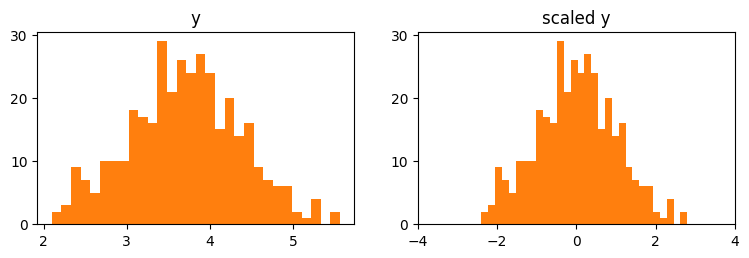

In [100]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 2.5))
ax[0].hist(ytr.reshape(1, -1), bins=30, color=cols[1])
ax[0].set_title("y")
ax[1].hist(scaled_ytr, bins=30, color=cols[1])
ax[1].set_title("scaled y")
ax[1].set_xlim(-4, 4)
plt.show()

This looks good! 

## Work on the Posterior Now!

Now lets try on the dataset. we fit additive models of `max_interaction_depth` 0 (i.e. a constant model), 1 and 2.

We can also look at the individual additive components learned by the second order model

In [101]:
# D = gpx.Dataset(X=scaled_Xtr, y=scaled_ytr)
# # noise = 0.01
# meanf = gpx.mean_function ds.Zero()
# base_kernels = [gpx.kernels.RBF(active_dims=[i], lengthscale=jnp.array([1.0])) for i in range(feature_dimension)]
# #base_kernels = [OrthogonalRBF(active_dims=[i], lengthscale=jnp.array([1.0])) for i in range(feature_dimension)]
# likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=noise)
# likelihood = likelihood.replace_trainable(obs_stddev=False)
# obj = gpx.objectives.ConjugateLOOCV(negative=True)
# maximum_interaction_depth = 2
# kernel = AdditiveKernel(
#     kernels=base_kernels,
#     interaction_variances=jnp.array([1.0]*(maximum_interaction_depth + 1)) * jnp.var(D.y), 
#     max_interaction_depth=maximum_interaction_depth, 
#     )
# prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
# posterior = AdditiveConjugatePosterior(prior =prior, likelihood=likelihood)
# opt_posterior, history = gpx.fit(
#     model=posterior,
#     objective=obj,
#     train_data=D,
#     optim=ox.adam(learning_rate=1e-2),
#     num_iters=1000,
#     key=key, 
#     safe=False,
#     verbose=False)
# plt.figure()
# plt.plot(history)
# pprint(opt_posterior.__dict__)


# plotting util


# plot 2d interaction
# ax[2].set_title(f"$f_3(x_1,x_2)$" if not sobol else f"$f_3(x_1,x_2)$ has sobol ${opt_posterior.get_sobol_index(D, [0, 1]):.2f}$")
# contour_plot(opt_posterior.predict_additive_component(xplot2d, D, [0, 1]).mean(), ax[2])

# plot learned additive components
# plot_posterior_with_components(opt_posterior)
# plt.show()

## Here we make the plotting functions for order 1 and 2 interaction levels

In [102]:
def plot_posterior_with_components(opt_posterior, sobol=False):
    fig, ax = plt.subplots(ncols=1, nrows=feature_dimension, figsize=(6, 6 * feature_dimension))
    for i in range(feature_dimension): # make 1d plots of 1d interactions
        posterior = opt_posterior.predict_additive_component(xplot1d, D, [i])
        mean, std = posterior.mean(), posterior.stddev()
        ax[i].plot(xplot1d[:,i], mean, color="blue", label="additive")
        ax[i].fill_between(xplot1d[:,i], mean - 2 * std,mean + 2 * std, alpha=0.2, color="blue")
        ax[i].set_title(f"$f_{i}(x_{i})$" if not sobol else f"$f_{i}(x_{i})$ has sobol ${opt_posterior.get_sobol_index(D, [i]):.2f}$")
        truth = lof[i](xplot1d[:,i])
        ax[i].plot(xplot1d[:,i], truth, color="black", label="truth")
        ax[i].legend()
        ax[i].scatter(scaled_Xtr[:,i], scaled_ytr, c="red", marker="x", label="data")
    # pprint(opt_posterior.__dict__)

def plot_posterior_with_components2d(opt_posterior, active_dimensions: list[int] = [0, 1], axis_to_plot = 0):
        if len(active_dimensions) not in [1,2]:
            raise ValueError("Only 1 or 2 active dimensions are supported")
        contour_plot(opt_posterior.predict_additive_component(
                mesh2d(active_dimensions=active_dimensions),
                D,
                [0, 1]
        ).mean(), ax[axis_to_plot])


## Here we test the above theory and code

In [103]:
from ChangingOptimiser import *

def f1(x):
    return 2*x**2
def f2(x):
    return jnp.sin(x)
def f3(x):
    return jnp.cos(x**2)
def f4(x):
    return 10*x
def f5(x):
    return 3*x**2 -1
def f6(x):
    return 4*x**3 - 3*x + 0.5
def f7(x):
    return x**4 - 4*x**2 + 2*x - 1


lof = [f1, f2, f3, f4, f5, f6, f7]

# path = "/home/sharmakd/python_dev/GPJax/docs/testingOAK/xsquared_sinx_cosxsquared"

# for variable_to_change in [1.0,
#                            1e-1,
#                         1e-2,
#                    ]:
#     print(variable_to_change)
#     generate_additive_plots(
#         list_of_functions=lof,
#         num_points=500,
#         type_of_points= "normal",
#         standard_deviation= 2,
#         bound_on_drawn_points = [-4, 4],
#         noise_level=variable_to_change,
#         train_test_split_value=0.01,
#         num_points_to_plot=100,
#         bounds = [-7, 7],
#         scale_X= False,
#         scale_y= False,
#         kernel_type= "RBF",
#         trainable_noise= True,
#         max_interaction_depth=2,
#         optimiser=ox.adam(learning_rate=0.1),
#         num_iters=200,
#         save_file = False,
#         save_file_name = "GraphAdamTrainable" + "NoiseLevel=" + str(variable_to_change),
#         path = path
#     )

1.0


## Here we test different optimisers from Optax to determine which works best

we implement the function *best_optimiser* which takes in a posterior and optimisers to optimise.

In [ ]:
def best_optimiser(
        D: gpx.Dataset = None,
        optimiser_list: list[ox.GradientTransformation] = None, 
        num_iters = 100,
        key: jr.PRNGKey = jr.PRNGKey(0),
        noises = 0.01,
        lengthscales = 1.0,
        trainable_noise: bool = True,
        ):
    if not isinstance(num_iters, list):
        if isinstance(num_iters, int):
            num_iters = [num_iters]
        else:
            raise ValueError("num_iters should be a list of integers")
    if len(num_iters) == 1:
        num_iters = num_iters * len(optimiser_list)
    else:
        assert len(num_iters) == len(optimiser_list), "Number of iterations should be same as number of optimisers"
    
    if not isinstance(noises, list):
        if isinstance(noises, Union[float, int]):
            noises = [noises]
        else:
            raise ValueError("Noises should be a list of floats or something like that")
    if len(noises) == 1:
        noises = noises * len(optimiser_list)
    else:
        assert len(noises) == len(optimiser_list), "Number of iterations should be same as number of optimisers"

    feature_dimension = X.shape[1]
    number_of_optimisers = len(optimiser_list)

    if not isinstance(lengthscales, list):
        if isinstance(lengthscales, Union[float, int]):
            lengthscales = [[lengthscales]*feature_dimension]
        else:
            raise ValueError("num_iters should be a list of integers")
    if len(lengthscales) == 1:
        lengthscales = lengthscales * len(optimiser_list)
    else:
        assert len(lengthscales) == len(optimiser_list), "Number of iterations should be same as number of optimisers"
    for index in range(number_of_optimisers):
        if isinstance(lengthscales[index], Union[float, int]):
            lengthscales[index] = [lengthscales[index]] * feature_dimension
        else:
            assert len(lengthscales[index]) == feature_dimension, "Lengthscales should be equal to feature dimension"

    # hi kishan

    opt_posteriors = []
    minimum_value = []
    index = list(range(number_of_optimisers))

    for i in range(number_of_optimisers):
        noise = noises[i]
        lengthscale = lengthscales[i]
        meanf = gpx.mean_functions.Zero()
        base_kernels = [gpx.kernels.RBF(
            active_dims=[i],
            lengthscale=jnp.array([lengthscale][j]
        )) for j in range(feature_dimension)]
        #base_kernels = [OrthogonalRBF(active_dims=[i], lengthscale=jnp.array([1.0])) for i in range(feature_dimension)]
        likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=noise)
        if not trainable_noise:
            likelihood = likelihood.replace_trainable(obs_stddev=False)
        obj = gpx.objectives.ConjugateLOOCV(negative=True)
        maximum_interaction_depth = 2
        kernel = AdditiveKernel(
            kernels=base_kernels,
            interaction_variances=jnp.array([1.0]*(maximum_interaction_depth + 1)) * jnp.var(D.y), 
            max_interaction_depth=maximum_interaction_depth, 
            )
        prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
        posterior = AdditiveConjugatePosterior(prior =prior, likelihood=likelihood)
        optimiser = optimiser_list[i]
        num_iter = num_iters[i]
        opt_posterior, history = gpx.fit(
            model=posterior,
            objective=obj,
            train_data=D,
            optim=optimiser,
            num_iters=num_iter,
            key=key, 
            safe=False,
            verbose=False)
        opt_posteriors.append(opt_posterior)
        minimum_value.append(history[-1])       
    values_to_return = sorted(zip(index,
                                optimiser_list, 
                                opt_posteriors, 
                                minimum_value,
                                noises, 
                                lengthscales
                                ), key = lambda x: x[3])
    return values_to_return 

In [81]:
D = gpx.Dataset(X=scaled_Xtr, y=scaled_ytr)
# noise = 0.01
meanf = gpx.mean_functions.Zero()
base_kernels = [gpx.kernels.RBF(active_dims=[i], lengthscale=jnp.array([1.0])) for i in range(feature_dimension)]
#base_kernels = [OrthogonalRBF(active_dims=[i], lengthscale=jnp.array([1.0])) for i in range(feature_dimension)]
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=noise)
likelihood = likelihood.replace_trainable(obs_stddev=False)
obj = gpx.objectives.ConjugateLOOCV(negative=True)
maximum_interaction_depth = 2
kernel = AdditiveKernel(
    kernels=base_kernels,
    interaction_variances=jnp.array([1.0]*(maximum_interaction_depth + 1)) * jnp.var(D.y), 
    max_interaction_depth=maximum_interaction_depth, 
    )
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
posterior = AdditiveConjugatePosterior(prior =prior, likelihood=likelihood)

optimiser_list = [ox.adam(learning_rate=0.1), 
                  ox.adam(learning_rate=0.01), 
                  ox.nadam(learning_rate=0.1),
                  ox.adamw(learning_rate=0.01),
                    ox.sgd(learning_rate=0.1),
                    ox.sgd(learning_rate=0.01),
                  ]
num_iters = 1000

optimised_posteriors  = best_optimiser(
    optimiser_list=optimiser_list,
    posterior=posterior,
    obj=obj,
    D=D,
    num_iters=num_iters,
    key=key
)

for index, x,y,z in optimised_posteriors:
    print(index)
    pprint(z)
    print("\n")


0
Array(-1848.602045, dtype=float64)


2
Array(-1848.59120926, dtype=float64)


5
Array(-1818.83280042, dtype=float64)


1
Array(-1799.89425636, dtype=float64)


3
Array(-1799.89133985, dtype=float64)


4
Array(1936.61447282, dtype=float64)


